<a href="https://colab.research.google.com/github/PradyumnaGupta/Suggestion_Mining/blob/master/Colab_Sugg_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install bert_tensorflow

     |████████████████████████████████| 71kB 4.9MB/s 


In [0]:
import pandas as pd 
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import backend as K
from bert.tokenization import FullTokenizer
import os 
import re
from tqdm import tqdm_notebook
import tqdm
sess=tf.Session()
#sess=tf.compat.v1.Session()

In [0]:
data_train=pd.read_csv("train.csv",header=None)
data_val=pd.read_csv("val_taska.csv",header=None)
data_test=pd.read_csv("eval.csv",header=None)
print(data_train.shape)
print(data_val.shape)
print(data_test.shape)

(8455, 2)
(592, 2)
(833, 2)


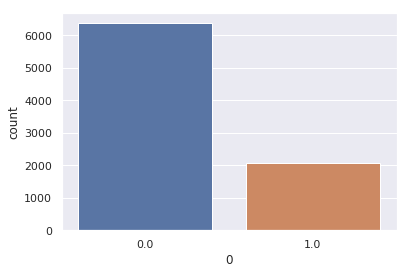

Suggestion Class= 2079
Non-Suggestion Class= 6376
Ratio= 0.3260664993726474


In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

fig=plt.figure()
sns.countplot(0,data=data_train)
plt.show()

print("Suggestion Class=",sum(data_train.iloc[:,0]==1))
print("Non-Suggestion Class=",sum(data_train.iloc[:,0]==0))
print("Ratio=",sum(data_train.iloc[:,0]==1)/sum(data_train.iloc[:,0]==0))

In [0]:
max_seq_length=max([len(x) for x in tqdm.tqdm(data_train.iloc[:,1])])
print(max_seq_length)

100%|██████████| 8455/8455 [00:00<00:00, 769125.54it/s]

2545


In [0]:
bert_path = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"
max_seq_length=256

In [0]:
# Create datasets (Only take up to max_seq_length words for memory)
train_text = data_train.iloc[:,1].tolist()
train_text = [' '.join(t.split()[0:max_seq_length]) for t in tqdm.tqdm(train_text)]
train_text = np.array(train_text, dtype=object)[:, np.newaxis]
train_label = data_train.iloc[:,0].tolist()

test_text = data_test.iloc[:,1].tolist()
test_text = [' '.join(t.split()[0:max_seq_length]) for t in tqdm.tqdm(test_text)]
test_text = np.array(test_text, dtype=object)[:, np.newaxis]
test_label = data_test.iloc[:,0].tolist()

val_text = data_val.iloc[:,1].tolist()
val_text = [' '.join(t.split()[0:max_seq_length]) for t in tqdm.tqdm(val_text)]
val_text = np.array(val_text, dtype=object)[:, np.newaxis]
val_label = data_val.iloc[:,0].tolist()


100%|██████████| 592/592 [00:00<00:00, 260330.04it/s]


In [0]:
class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        """Constructs a InputExample.
    Args:
      guid: Unique id for the example.
      text_a: string. The untokenized text of the first sequence. For single
        sequence tasks, only this sequence must be specified.
      text_b: (Optional) string. The untokenized text of the second sequence.
        Only must be specified for sequence pair tasks.
      label: (Optional) string. The label of the example. This should be
        specified for train and dev examples, but not for test examples.
    """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label        

In [0]:
class PaddingInputExample(object):
  pass
def create_tokenizer_from_hub_module():
    """Get the vocab file and casing info from the Hub module."""
    bert_module =  hub.Module(bert_path)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    vocab_file, do_lower_case = sess.run(
        [
            tokenization_info["vocab_file"],
            tokenization_info["do_lower_case"],
        ]
    )

    return FullTokenizer(vocab_file=vocab_file, do_lower_case=do_lower_case)
def convert_single_example(tokenizer, example, max_seq_length=max_seq_length):
    """Converts a single `InputExample` into a single `InputFeatures`."""

    if isinstance(example, PaddingInputExample):
        input_ids = [0] * max_seq_length
        input_mask = [0] * max_seq_length
        segment_ids = [0] * max_seq_length
        label = 0
        return input_ids, input_mask, segment_ids, label

    tokens_a = tokenizer.tokenize(example.text_a)
    if len(tokens_a) > max_seq_length - 2:
        tokens_a = tokens_a[0 : (max_seq_length - 2)]

    tokens = []
    segment_ids = []
    tokens.append("[CLS]")
    segment_ids.append(0)
    for token in tokens_a:
        tokens.append(token)
        segment_ids.append(0)
    tokens.append("[SEP]")
    segment_ids.append(0)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    while len(input_ids) < max_seq_length:
        input_ids.append(0)
        input_mask.append(0)
        segment_ids.append(0)

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length

    return input_ids, input_mask, segment_ids, example.label

def convert_examples_to_features(tokenizer, examples, max_seq_length=max_seq_length):
    """Convert a set of `InputExample`s to a list of `InputFeatures`."""

    input_ids, input_masks, segment_ids, labels = [], [], [], []
    for example in tqdm_notebook(examples, desc="Converting examples to features"):
        input_id, input_mask, segment_id, label = convert_single_example(
            tokenizer, example, max_seq_length
        )
        input_ids.append(input_id)
        input_masks.append(input_mask)
        segment_ids.append(segment_id)
        labels.append(label)
    return (
        np.array(input_ids),
        np.array(input_masks),
        np.array(segment_ids),
        np.array(labels).reshape(-1, 1),
    )
def convert_text_to_examples(texts, labels):
    """Create InputExamples"""
    InputExamples = []
    for text, label in zip(texts, labels):
        InputExamples.append(
            InputExample(guid=None, text_a=" ".join(text), text_b=None, label=label)
        )
    return InputExamples


In [0]:
tokenizer = create_tokenizer_from_hub_module()
train_examples = convert_text_to_examples(train_text, train_label)
test_examples = convert_text_to_examples(test_text, test_label)
val_examples = convert_text_to_examples(val_text, val_label)
# Convert to features
(train_input_ids, train_input_masks, train_segment_ids, train_labels 
) = convert_examples_to_features(tokenizer, train_examples, max_seq_length=max_seq_length)
(test_input_ids, test_input_masks, test_segment_ids, test_labels
) = convert_examples_to_features(tokenizer, test_examples, max_seq_length=max_seq_length)
(val_input_ids, val_input_masks, val_segment_ids, val_labels
) = convert_examples_to_features(tokenizer, val_examples, max_seq_length=max_seq_length)

In [0]:
#import keras
class BertLayer(tf.keras.layers.Layer):
    def __init__(self, n_fine_tune_layers=10, **kwargs):
        self.n_fine_tune_layers = n_fine_tune_layers
        self.trainable = True
        self.output_size = 768
        super(BertLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.bert = hub.Module(
            bert_path,
            trainable=True,# did this in place of self.trainable
            name="{}_module".format(self.name)
        )

        trainable_vars = self.bert.variables

        
        trainable_vars = [var for var in trainable_vars if not "/cls/" in var.name]

        # Select how many layers to fine tune
        #trainable_vars = trainable_vars[-self.n_fine_tune_layers :]

        # Add to trainable weights
        for var in trainable_vars:
            self._trainable_weights.append(var)
            
        for var in self.bert.variables:
            if var not in self._trainable_weights:
                self._non_trainable_weights.append(var)

        super(BertLayer, self).build(input_shape)

    def call(self, inputs):
        inputs = [K.cast(x, dtype="int32") for x in inputs]
        input_ids, input_mask, segment_ids = inputs
        bert_inputs = dict(
            input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids
        )
        result = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)[
            "pooled_output"
        ]
        return result

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_size)

In [0]:
from tensorflow.keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [0]:
for lr in [3e-4]:
    for epochs in [1]:
        for dropout in [0.3]:
            for layers in [2]: 
                #with tf.device('/GPU:2'):
                sess=tf.Session()
                #sess=tf.Session(config=tf.ConfigProto(allow_soft_placement=True))
                from tensorflow.keras.layers import Input,Dense
                in_id=Input(shape=(max_seq_length,),)
                in_mask=Input(shape=(max_seq_length,),)
                in_segment=Input(shape=(max_seq_length,),)
                in_id = tf.keras.layers.Input(shape=(max_seq_length,))
                in_mask = tf.keras.layers.Input(shape=(max_seq_length,))
                in_segment = tf.keras.layers.Input(shape=(max_seq_length,))
                bert_inputs=[in_id,in_mask,in_segment]
                bert_outputs=BertLayer(n_fine_tune_layers=10)(bert_inputs)
                step=bert_outputs
                if layers>=3:
                    step=tf.keras.layers.Dense(512,activation='relu')(step)
                    if dropout!=0:
                        step=tf.keras.layers.Dropout(rate=dropout)(step)
                if layers>=2:
                    step=tf.keras.layers.Dense(256,activation='relu')(step)
                    if dropout!=0:
                        step=tf.keras.layers.Dropout(rate=dropout)(step)
                if layers>=1:    
                    step=tf.keras.layers.Dense(64,activation='relu')(step)
                    if dropout!=0:
                        step=tf.keras.layers.Dropout(rate=dropout)(step)
                pred=tf.keras.layers.Dense(1,activation='sigmoid')(step)
                model=tf.keras.Model(inputs=bert_inputs,outputs=pred)
                model.compile(loss='binary_crossentropy',
                        optimizer=tf.keras.optimizers.Adam(lr=lr),
                        metrics=[f1,'accuracy'])
          #tpu_model = tf.contrib.tpu.keras_to_tpu_model(model,
                                                        #strategy=tf.contrib.tpu.TPUDistributionStrategy(tf.contrib.cluster_resolver.TPUClusterResolver(tpu_address)))

                sess.run(tf.local_variables_initializer())
                sess.run(tf.global_variables_initializer())
                sess.run(tf.tables_initializer())
                K.set_session(sess)
                #model=tf.keras.models.load_model('my_model.h5')


                model.fit([train_input_ids, train_input_masks, train_segment_ids],
                        train_labels,
                        epochs=epochs,
                        batch_size=32,
                        validation_data=([val_input_ids, val_input_masks, val_segment_ids],val_labels))
                        
                from sklearn.metrics import f1_score,accuracy_score
                predict=model.predict([test_input_ids,test_input_masks,test_segment_ids])>0.5
                print("task_a=",f1_score(test_labels,predict),"  acc=",accuracy_score(test_labels,predict))
                predict2=model.predict([test2_input_ids,test2_input_masks,test2_segment_ids])>0.5
                print("task_b=",f1_score(test2_labels,predict2),"    acc=",accuracy_score(test2_labels,predict2))                        


In [0]:
class BertLayer(tf.keras.layers.Layer):
                    def __init__(self, n_fine_tune_layers=10, **kwargs):
                        self.n_fine_tune_layers = n_fine_tune_layers
                        self.trainable = True
                        self.output_size = 768
                        super(BertLayer, self).__init__(**kwargs)

                    def build(self, input_shape):
                        self.bert = hub.Module(
                        bert_path,
                        trainable=True,# did this in place of self.trainable
                        name="{}_module".format(self.name)
                      )

                        trainable_vars = self.bert.variables


                        trainable_vars = [var for var in trainable_vars if not "/cls/" in var.name]
                        #print("--------------------------len=",len(trainable_vars))
                        # Select how many layers to fine tune
                        trainable_vars = trainable_vars[-self.n_fine_tune_layers:]

                        # Add to trainable weights
                        for var in trainable_vars:
                            self._trainable_weights.append(var)

                        for var in self.bert.variables:
                            if var not in self._trainable_weights:
                                self._non_trainable_weights.append(var)

                        super(BertLayer, self).build(input_shape)

                    def call(self, inputs):
                        inputs = [K.cast(x, dtype="int32") for x in inputs]
                        input_ids, input_mask, segment_ids = inputs
                        bert_inputs = dict(
                          input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids
                      )
                        result = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)[
                          "pooled_output"
                      ]
                        return result

                    def compute_output_shape(self, input_shape):
                        return (input_shape[0], self.output_size)

In [51]:
with tf.keras.utils.CustomObjectScope({'BertLayer' : BertLayer(n_fine_tune_layers=10)}):
    with tf.keras.utils.CustomObjectScope({'f1':f1}):    
        model=tf.keras.models.load_model('my_model.h5')
        model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
bert_layer (BertLayer)          (None, 768)          110104890   input_4[0][0]                    
                                                                 input_5[0][0]                

In [52]:
from sklearn.metrics import f1_score,accuracy_score
predict=model.predict([test_input_ids,test_input_masks,test_segment_ids])>0.5
print("task_a=",f1_score(test_labels,predict),"  acc=",accuracy_score(test_labels,predict))
#predict2=model.predict([test2_input_ids,test2_input_masks,test2_segment_ids])>0.5
#print("task_b=",f1_score(test2_labels,predict2),"    acc=",accuracy_score(test2_labels,predict2))

task_a= 0.770949720670391   acc= 0.9507803121248499
